# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [10]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

#sent_4900 = final['Text'].values[4900]
#print(sent_4900)
#print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
#sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

#soup = BeautifulSoup(sent_4900, 'lxml')
#text = soup.get_text()
#print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he has not had a UTI for a year.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My husband is a paraplegic and was having UTIs constantly Since he started drinking a cup of this tea every morning he has not had a UTI for a year 


In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() )
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 54456/54456 [00:22<00:00, 2388.99it/s]


In [22]:
preprocessed_reviews[3]

'we have used the victor fly bait for seasons ca not beat it great product'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [23]:
## Similartly you can do preprocessing for review summary also.
len(preprocessed_reviews)

54456

In [24]:
labels = final.head(50000)['Score']

In [25]:
X_train, X_test,y_train , y_test = cross_validation.train_test_split(preprocessed_reviews[:50000],labels, test_size=0.3, random_state=0)

In [26]:
X_train[1]

'long story short creamers thrown into single box no protection opened box and there was liquid creamer all over the contents think twice before oredering or subscribing'

In [27]:
from collections import Counter
cnt = Counter()
for rev in X_train:
    #print(rev)
    for word in rev.split(" "):
        cnt[word] += 1

In [28]:
fre_lst = [w[0] for w in sorted(cnt.items(),key=lambda x:x[1],reverse=True)[:5000]]

In [29]:
final_X_train=[]
a=[]
for i in X_train:
    a=[]
    for j in i.split(" "):
        if j in cnt.keys():
            try:
                a.append(fre_lst.index(j)+1)
            except:
                pass
       
    final_X_train.append(a)

In [30]:
final_X_test=[]
a=[]
for i in X_test:
    a=[]
    for j in i.split(" "):
        if j in cnt.keys():
            try:
                a.append(fre_lst.index(j)+1)
            except:
                pass
       
    final_X_test.append(a)

<h2>Applying LSTM Model 

In [2]:
import numpy
#!pip install --upgrade tensorflow-gpu
from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


  Using cached https://files.pythonhosted.org/packages/32/67/559ca8408431c37ad3a17e859c8c291ea82f092354074baef482b98ffb7b/tensorflow_gpu-1.14.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9d/b1/b80dea9e0bbbdd07bf7ba69c6df1aeb3e88b90b85ca326c40be9e29bc37c/grpcio-1.22.0-cp37-cp37m-manylinux1_x86_64.whl
  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f13ba3630b8>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /packages/95/ad/682b9dd1b

In [32]:
max_review_length = 600
X_train = sequence.pad_sequences(final_X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(final_X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(35000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

<h2>Model 1

In [33]:
top_words=5000
embedding_vecor_length = 32

In [34]:

# create the model

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 32)           160032    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 571s 16ms/step - loss: 0.3864 - acc: 0.8477 - val_loss: 0.2984 - val_acc: 0.8798
Epoch 2/10
35000/35000 [==============================] - 566s 16ms/step - loss: 0.2509 - acc: 0.8983 - val_loss: 0.2423 - val_acc: 0.8991
Epoch 3/10
35000/35000 [==============================] - 617s 18ms/step - loss: 0.1992 - acc: 0.9210 - val_loss: 0.2367 - val_acc: 0.9009
Epoch 4/10
35000/35000 [==============================] - 621s 18ms/step - loss: 0.1762 - acc: 0.9318 - val_loss: 0.2202 - val_acc: 0.9105
Epoch 5/10
35000/35000 [==============================] - 561s 16ms/step - loss: 0.1637 - acc: 0.9372 - val_loss: 0.2547 - val_acc: 0.8905
Epoch 6/10
35000/35000 [==============================] - 653s 19ms/step - loss: 0.1607 - acc: 0.9375 - val_loss: 0.2489 - val_acc: 0.9105
Epoch 7/10
35000/35000 [==============================] - 598s 17ms/step - loss: 0.1399 - acc: 0.9477 - val_loss: 0.

<h2>Model 2

In [38]:
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(100, return_sequences=True))
model2.add(LSTM(100))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history2 = model2.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 1099s 31ms/step - loss: 0.3828 - acc: 0.8518 - val_loss: 0.3002 - val_acc: 0.8845
Epoch 2/10
35000/35000 [==============================] - 1099s 31ms/step - loss: 0.2372 - acc: 0.9053 - val_loss: 0.2862 - val_acc: 0.8942
Epoch 3/10
35000/35000 [==============================] - 1098s 31ms/step - loss: 0.1960 - acc: 0.9242 - val_loss: 0.2404 - val_acc: 0.9056
Epoch 4/10
35000/35000 [==============================] - 1099s 31ms/step - loss: 0.1714 - acc: 0.9338 - val_loss: 0.2367 - val_acc: 0.9076
Epoch 5/10
35000/35000 [==============================] - 1102s 31ms/step - loss: 0.1570 - acc: 0.9404 - val_loss: 0.2409 - val_acc: 0.9011
Epoch 6/10
35000/35000 [==============================] - 1105s 32ms/step - loss: 0.1422 - acc: 0.9464 - val_loss: 0.2190 - val_acc: 0.9141
Epoch 7/10
35000/35000 [==============================] - 1110s 32ms/step - loss: 0.1241 - acc: 0.9535 - val_l

<h2>Model 3

In [36]:

# create the model

model3 = Sequential()
model3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model3.add(LSTM(100))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
history3 = model3.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 646s 18ms/step - loss: 0.4304 - acc: 0.8347 - val_loss: 0.4193 - val_acc: 0.8393
Epoch 2/10
35000/35000 [==============================] - 539s 15ms/step - loss: 0.3161 - acc: 0.8722 - val_loss: 0.2800 - val_acc: 0.8865
Epoch 3/10
35000/35000 [==============================] - 531s 15ms/step - loss: 0.2242 - acc: 0.9101 - val_loss: 0.2560 - val_acc: 0.8972
Epoch 4/10
35000/35000 [==============================] - 593s 17ms/step - loss: 0.1932 - acc: 0.9237 - val_loss: 0.2384 - val_acc: 0.9100
Epoch 5/10
35000/35000 [==============================] - 580s 17ms/step - loss: 0.1661 - acc: 0.9351 - val_loss: 0.2252 - val_acc: 0.9107
Epoch 6/10
35000/35000 [==============================] - 544s 16ms/step - loss: 0.1487 - acc: 0.9450 - val_loss: 0.2142 - val_acc: 0.9126
Epoch 7/10
35000/35000 [==============================] - 657s 19ms/step - loss: 0.1297 - acc: 0.9523 - val_loss: 0.

<H2>Error Plots

<IPython.core.display.Javascript object>


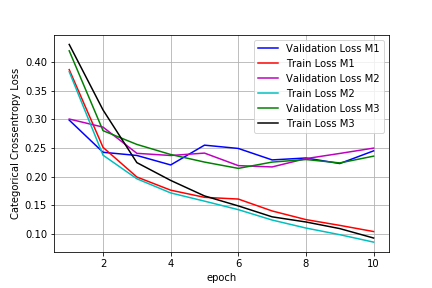

In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time   
    
epochs=10
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss M1")
ax.plot(x, ty, 'r', label="Train Loss M1")
vy = history2.history['val_loss']
ty = history2.history['loss']
ax.plot(x, vy, 'm', label="Validation Loss M2")
ax.plot(x, ty, 'c', label="Train Loss M2")
vy = history3.history['val_loss']
ty = history3.history['loss']
ax.plot(x, vy, 'g', label="Validation Loss M3")
ax.plot(x, ty, 'k', label="Train Loss M3")

plt.legend()  
plt.grid()
fig.canvas.draw()

# [6] Conclusions

In [41]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","LSTM layers", "Accuracy"]

x.add_row(["Model 1","One Layer",91.65])
x.add_row(["Model 2","Two Layers",91.89])
x.add_row(["Model 3","One Layer",90.70])


print(x)

+---------+-------------+----------+
|  Model  | LSTM layers | Accuracy |
+---------+-------------+----------+
| Model 1 |  One Layer  |  91.65   |
| Model 2 |  Two Layers |  91.89   |
| Model 3 |  One Layer  |   90.7   |
+---------+-------------+----------+
